In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, QuantileTransformer, Normalizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, make_scorer


from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import VarianceThreshold, RFECV

import joblib
import shap

In [39]:
file_path = r'\02_[homeloan]_train_data_preparation.csv'
cust_behavior_df = pd.read_csv(file_path)
cust_behavior_df

,sk_id_curr,target,app_amt_income_total,app_ext_source_1,app_ext_source_2,app_ext_source_3,app_amt_credit,app_amt_annuity,app_amt_goods_price,app_cnt_children,...,cc_bal_sk_dpd_def_sum,cc_bal_sk_dpd_def_std,cc_bal_name_contract_status_active,cc_bal_name_contract_status_approved,cc_bal_name_contract_status_completed,cc_bal_name_contract_status_demand,cc_bal_name_contract_status_refused,cc_bal_name_contract_status_sentproposal,cc_bal_name_contract_status_signed,cc_bal_num_cc_txn
0,100002,1,202500.0,0.083037,0.262949,0.139376,406597.5,24700.5,351000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,270000.0,0.311267,0.622246,0.000000,1293502.5,35698.5,1129500.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,67500.0,0.000000,0.555912,0.729567,135000.0,6750.0,135000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,135000.0,0.000000,0.650442,0.000000,312682.5,29686.5,297000.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,100007,0,121500.0,0.000000,0.322738,0.000000,513000.0,21865.5,513000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,157500.0,0.145570,0.681632,0.000000,254700.0,27558.0,225000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,72000.0,0.000000,0.115992,0.000000,269550.0,12001.5,225000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,153000.0,0.744026,0.535722,0.218859,677664.0,29979.0,585000.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307509,456254,1,171000.0,0.000000,0.514163,0.661024,370107.0,20205.0,319500.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='target', ylabel='count'>

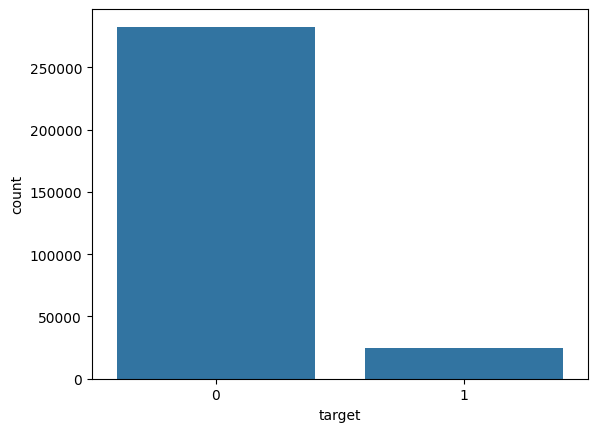

In [63]:
sns.countplot(data=cust_behavior_df, x="target")

<Axes: xlabel='app_amt_annuity', ylabel='app_amt_credit'>

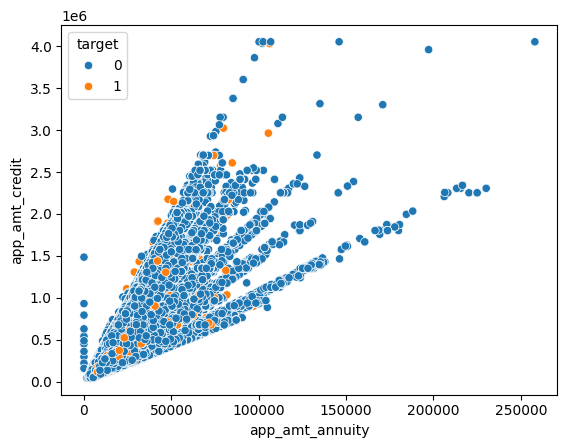

In [61]:
sns.scatterplot(data=cust_behavior_df, x="app_amt_annuity", y="app_amt_credit", hue="target")

In [55]:
def as_type(df):

    key_cols = ['Customer_ID', 'Feature_Date', 'Target_Date', 'Target']

    cat_cols = list()
    int_cols = list()
    float_cols = list()

    for col in df.columns:
        if col not in key_cols:
            if df[col].dtype == 'object':
                cat_cols.append(col)
            elif df[col].dtype == 'int64':
                int_cols.append(col)
            else:
                float_cols.append(col)

    print("cat_columns:", len(cat_cols))
    print("int_columns:", len(int_cols))
    print("float_columns:", len(float_cols))

    df[cat_cols] = df[cat_cols].fillna('na').astype('category')
    df[int_cols] = df[int_cols].fillna(0)
    df[float_cols] = df[float_cols].fillna(0)
    df['Target'] = df['Target'].astype('int64')

    return cat_cols, int_cols, float_cols, df

def prepare_X_y(df, keys:list):

    keys = [key.lower() for key in keys]
    drop_cols = [col for col in df.columns if col in keys]
    # print(drop_cols)

    if len(drop_cols) > 0:
        X = df.drop(columns=drop_cols, axis=1)
    else:
        X = df

    y = df[['target']]

    return X, y

def xgb_model(df):
    
    #cut-off missing value at < 90%
    # missing_df = missing_value(df=cust_behavior_df)
    # missing_value_cutoff_threshold = 90
    # feature_used = missing_df[missing_df['Missing_Percentage'] < missing_value_cutoff_threshold]['Feature'].tolist()

    print('data set: ', df.shape)
    X, y = prepare_X_y(df=df, keys=['sk_id_curr', 'target'])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 555, stratify=y)
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    scale_pos_weight = (len(y_train[y_train['target'] == 0]) / len(y_train[y_train['target'] == 1]))

    params = {
            'learning_rate': 0.03,
            'max_depth': 7,
            'eval_metric' : 'auc',
            'scale_pos_weight': scale_pos_weight*1.5,
            'min_child_weight': 3,
            'n_estimators' : 900,
            } 

    early_stopping_callback = EarlyStopping(rounds=100, save_best=True, maximize=True)

    xgb_model = XGBClassifier(**params)
    xgb_model.set_params(callbacks=[early_stopping_callback])
    xgb_model.fit(
                    X_train, y_train,
                    eval_set=[(X_train, y_train), (X_test, y_test)],
                    verbose=100
                )

    return df_train, df_test, xgb_model

def save_model(model, path):
    joblib.dump(model, path)
    print('save model is done..')

def evaluate_model(df_train, df_test, model, keys):
    
    X_train, y_train = prepare_X_y(df=df_train, keys=keys)
    X_test, y_test = prepare_X_y(df=df_test, keys=keys)

    score_list = list()
    eval_list = ['Train', 'Test']
    x_list = [X_train, X_test]
    y_list = [y_train, y_test]
    fpr_list = list()
    tpr_list = list()
    auc_list = list()

    for i in range(len(eval_list)):
        print('Predict {}:'.format(eval_list[i]))
        y_pred = model.predict(x_list[i])
        y_pred_prob = model.predict_proba(x_list[i])

        plt.figure(figsize=(5, 3))
        cm = confusion_matrix(y_list[i], y_pred)
        cm_matrix = pd.DataFrame(data=cm)
        g = sns.heatmap(data=cm_matrix, annot=True, fmt='g')
        g.set_title('Confustion Matrix {}'.format(eval_list[i]))
        g.set(xlabel="Predicted Class", ylabel="Actual Class")
        plt.show()

        acc = np.round(accuracy_score(y_list[i], y_pred), decimals=3)
        auc = np.round(roc_auc_score(y_list[i], y_pred_prob[:,1]), decimals=3)
        prcn = np.round(precision_score(y_list[i], y_pred), decimals=3)
        recl = np.round(recall_score(y_list[i], y_pred), decimals=3)
        f1sc = np.round(f1_score(y_list[i], y_pred), decimals=3)

        score_list.append('{}: XGBoost'.format(eval_list[i]))
        score_list.append(model.get_params)
        score_list.append(x_list[i].shape[0])
        score_list.append(x_list[i].shape[1])
        score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))
        score_list.append(acc)
        score_list.append(auc)
        score_list.append(prcn)
        score_list.append(recl)
        score_list.append(f1sc)
        
        auc_list.append(auc)

        fpr, tpr, threshold = roc_curve(y_list[i], y_pred_prob[:,1])
        fpr_list.append(fpr)
        tpr_list.append(tpr)

    plt.figure(figsize=(6, 4))
    
    label_positions = [(0.95, 0.5), (0.95, 0.4)]
    label_list = list()
    
    for i in range(len(eval_list)):
        text = f"{eval_list[i]} (AUC: {auc_list[i]})"
        label_list.append(text)

    for i in range(len(label_positions)):
        plt.plot(fpr_list[i], tpr_list[i], label=eval_list[i])
        pos_x, pos_y = label_positions[i]
        plt.text(pos_x, pos_y, label_list[i], verticalalignment='bottom', horizontalalignment='right')
        
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positve Rate')
    plt.title('ROC')
    plt.plot([0,1],[0,1], 'k--')
    plt.show()
        
    score_list_data = np.reshape(np.array(score_list), (len(eval_list), 10))
    score_list_df = pd.DataFrame(data=score_list_data, columns=['model_name', 'parameters', 'rows', 'columns', '%_target', 'accuracy', 'auc', 'precision', 'recall', 'f1-score']).reset_index(drop=True)

    return score_list_df

def feature_importance(model):

    dict_feature_importance = {
                                'feature_name':model.feature_names_in_,
                                'feature_importance':model.feature_importances_
                              }

    df_feature_importance = pd.DataFrame(dict_feature_importance).sort_values('feature_importance', ascending=False)
    df_feature_importance['feature_importance'] = np.round(df_feature_importance['feature_importance'], 5)
    df_feature_importance['pct'] = np.round(df_feature_importance['feature_importance']/df_feature_importance['feature_importance'].sum() * 100, 3)
    df_feature_importance['cum_pct'] = np.round(df_feature_importance['pct'].cumsum(), 3)
    df_feature_importance['pct_diff'] = np.round(df_feature_importance['feature_importance'].pct_change().abs() * 100, 3)
    df_feature_importance = df_feature_importance.reset_index(drop=True)
    df_feature_importance.index = df_feature_importance.index + 1
    
    return df_feature_importance

def missing_value(df):
    
    missing_percentages = df.isnull().mean()
    missing_df = pd.DataFrame({
        'Feature': missing_percentages.index,
        'Missing_Percentage': missing_percentages.values
    })

    return missing_df

def missing_ft_reduction(df, threshold: float):
    
    missing_df = missing_value(df=df)
    feature_used = missing_df[missing_df['Missing_Percentage'] < threshold]['Feature'].tolist()
    df_reduced = df[feature_used]
    
    return df_reduced

def corr_ft_reduction(df, threshold:float):
    
    correlation_matrix = df.corr()
    corr_matrix_abs = correlation_matrix.abs()

    high_corr_pairs = (corr_matrix_abs.where(corr_matrix_abs > threshold)
                    .stack()
                    .reset_index()
                    .query("level_0 != level_1"))

    high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

    features_to_remove = []
    for index, row in high_corr_pairs.iterrows():
        feature1 = row['Feature1']
        feature2 = row['Feature2']
        corr_with_target_f1 = abs(correlation_matrix[feature1]['target'])
        corr_with_target_f2 = abs(correlation_matrix[feature2]['target'])
        
        if corr_with_target_f1 < corr_with_target_f2:
            features_to_remove.append(feature1)
        else:
            features_to_remove.append(feature2)

    features_to_remove = list(set(features_to_remove))
    df_reduced = df.drop(columns=features_to_remove)
    
    return df_reduced

def var_ft_reduction(df, threshold:float):
    
    df_var = df.copy()
    selector = VarianceThreshold(threshold=threshold)
    X_reduced = selector.fit_transform(df_var.drop(columns='target', axis=1))
    retained_features = df_var.columns[selector.get_support(indices=True)]
    df_reduced = pd.DataFrame(X_reduced, columns=retained_features)
    df_reduced['target'] = df['target']
    
    return df_reduced

Run Model

In [14]:
df_train, df_test, xgb_model = xgb_model(df=cust_behavior_df)

data set:  (307511, 206)
[0]	validation_0-auc:0.72903	validation_1-auc:0.71234
[100]	validation_0-auc:0.79649	validation_1-auc:0.75177
[200]	validation_0-auc:0.82041	validation_1-auc:0.75807
[300]	validation_0-auc:0.83615	validation_1-auc:0.75895
[400]	validation_0-auc:0.84860	validation_1-auc:0.75883
[429]	validation_0-auc:0.85200	validation_1-auc:0.75864


Save Train Test Data

In [15]:
train_file_path = r'\02_[homeloan]_train_df.csv'
test_file_path = r'\02_[homeloan]_test_df.csv'
df_train.to_csv(train_file_path, index=False)
df_test.to_csv(test_file_path, index=False)

Load Train Test Data

In [41]:
train_file_path = r'\02_[homeloan]_train_df.csv'
test_file_path = r'\02_[homeloan]_test_df.csv'
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

Save Model

In [152]:
save_model(model=xgb_model, path=r'\03_[model]_pd_model.pkl')

save model is done..


Load Model

In [43]:
#load model
xgb_model_load = joblib.load(r'\03_[model]_pd_model.pkl')
print(type(xgb_model_load))

<class 'xgboost.sklearn.XGBClassifier'>


Model Evaluation

Predict Train:


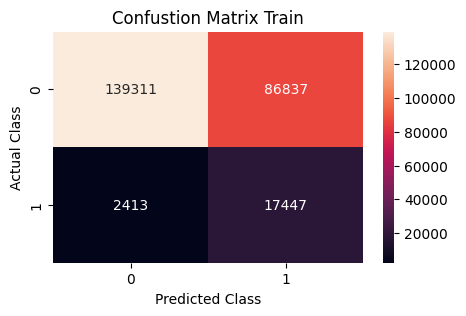

C:\Users\tanap\AppData\Local\Temp\ipykernel_42308\2369474014.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


Predict Test:


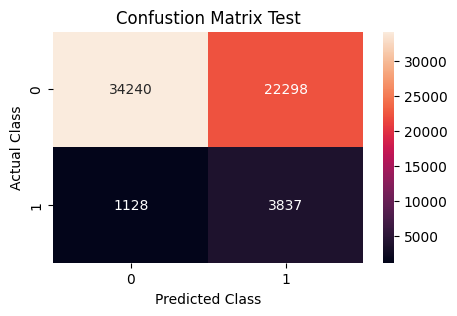

C:\Users\tanap\AppData\Local\Temp\ipykernel_42308\2369474014.py:130: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


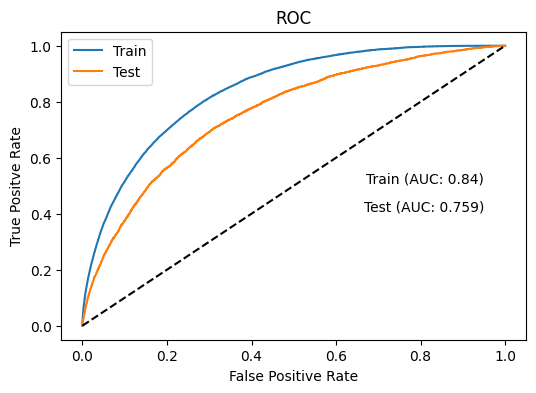

In [18]:
score_list_df = evaluate_model(df_train=df_train, df_test=df_test, model=xgb_model_load, keys=['sk_id_curr', 'target'])

In [19]:
score_list_df

,model_name,parameters,rows,columns,%_target,accuracy,auc,precision,recall,f1-score
0,Train: XGBoost,<bound method XGBModel.get_params of XGBClassi...,246008,204,8,0.637,0.84,0.167,0.878,0.281
1,Test: XGBoost,<bound method XGBModel.get_params of XGBClassi...,61503,204,8,0.619,0.759,0.147,0.773,0.247


In [44]:
feature_importance_df = feature_importance(model=xgb_model_load)
feature_importance_df

,feature_name,feature_importance,pct,cum_pct,pct_diff
1,app_ext_source_3,0.03621,3.621,3.621000,NaN
2,app_ext_source_2,0.03500,3.500,7.121000,3.342
3,app_flag_emp_phone,0.01907,1.907,9.028000,45.514
4,bureau_credit_type_microloan,0.01723,1.723,10.751000,9.649
5,cc_bal_cnt_drawings_atm_current_mean,0.01379,1.379,12.130000,19.965
...,...,...,...,...,...
200,cc_bal_cnt_drawings_other_current_min,0.00000,0.000,99.999001,NaN
201,bureau_credit_type_loanforpurchaseofsharesmarg...,0.00000,0.000,99.999001,NaN
202,bureau_credit_type_interbankcredit,0.00000,0.000,99.999001,NaN
203,cc_bal_cnt_drawings_other_current_max,0.00000,0.000,99.999001,NaN


In [47]:
df_feature_importance_perc_above_0 = feature_importance_df[feature_importance_df['pct'] > 0]
list_feature_importance_perc_above_0 = df_feature_importance_perc_above_0['feature_name'].tolist()

df_feature_importance_cumsum_80 = feature_importance_df[feature_importance_df['cum_pct'] <= 0.8]
list_feature_importance_cumsum_80 = df_feature_importance_cumsum_80['feature_name'].tolist()

In [48]:
df_feature_importance_perc_above_0

,feature_name,feature_importance,pct,cum_pct,pct_diff
1,app_ext_source_3,0.03621,3.621,3.621000,NaN
2,app_ext_source_2,0.03500,3.500,7.121000,3.342000
3,app_flag_emp_phone,0.01907,1.907,9.028000,45.514000
4,bureau_credit_type_microloan,0.01723,1.723,10.751000,9.649000
5,cc_bal_cnt_drawings_atm_current_mean,0.01379,1.379,12.130000,19.965000
...,...,...,...,...,...
174,cc_bal_cnt_drawings_pos_current_min,0.00206,0.206,99.570999,18.898001
175,bureau_credit_day_overdue_mean,0.00157,0.157,99.727997,23.785999
176,cc_bal_amt_drawings_current_min,0.00123,0.123,99.850998,21.656000
177,cc_bal_amt_total_receivable_max,0.00087,0.087,99.938004,29.268000


In [49]:
keys =['sk_id_curr']

df_ft_reduction = df_train.copy()
print('Step 0:', df_ft_reduction.shape)

df_ft_reduction = missing_ft_reduction(df=df_ft_reduction, threshold=0.9)
print('Step 1:', df_ft_reduction.shape)

df_feature_importance_perc_above_0 = feature_importance_df[feature_importance_df['pct'] > 0]
list_feature_importance_perc_above_0 = df_feature_importance_perc_above_0['feature_name'].tolist()
df_ft_reduction = df_ft_reduction[['target'] + list_feature_importance_perc_above_0]
print('Step 2:', df_ft_reduction.shape)

df_ft_reduction = corr_ft_reduction(df=df_ft_reduction, threshold=0.8)
print('Step 3:', df_ft_reduction.shape)

df_ft_reduction = var_ft_reduction(df=df_ft_reduction, threshold=0.01)
print('Step 4:', df_ft_reduction.shape)

df_ft_reduction = df_ft_reduction.drop(columns='target', axis=1)
list_ft_reduction = df_ft_reduction.columns.tolist()

Step 0: (246008, 205)
Step 1: (246008, 205)
Step 2: (246008, 179)
Step 3: (246008, 102)
Step 4: (246008, 94)


In [179]:
cust_behavior_df[keys+list_ft_reduction].shape

(307511, 96)

In [52]:
keys =['sk_id_curr', 'target']
df_train_re, df_test_re, xgb_model_re = xgb_model(df=cust_behavior_df[keys+list_ft_reduction])

data set:  (307511, 95)
['sk_id_curr', 'target']
[0]	validation_0-auc:0.72885	validation_1-auc:0.71113
[100]	validation_0-auc:0.79349	validation_1-auc:0.75115
[200]	validation_0-auc:0.81678	validation_1-auc:0.75670
[300]	validation_0-auc:0.83324	validation_1-auc:0.75749
[400]	validation_0-auc:0.84567	validation_1-auc:0.75737
[460]	validation_0-auc:0.85213	validation_1-auc:0.75711


Save Model (Feature Reduction)

In [225]:
save_model(model=xgb_model_re, path=r'\03_[model]_pd_model_re.pkl')

save model is done..


Load Model (Feature Reduction)

In [35]:
#load model
xgb_model_re_load = joblib.load(r'\03_[model]_pd_model_re.pkl')
print(type(xgb_model_re_load))

<class 'xgboost.sklearn.XGBClassifier'>


['target']
['target']
Predict Train:


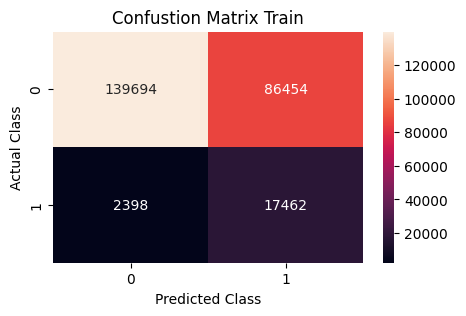

C:\Users\tanap\AppData\Local\Temp\ipykernel_27992\2762396326.py:120: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


Predict Test:


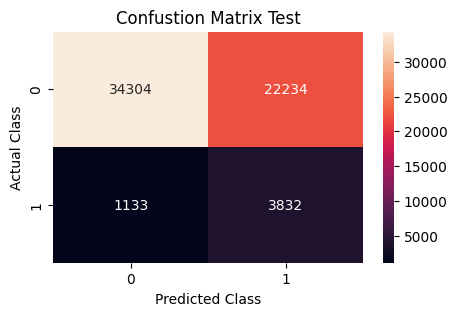

C:\Users\tanap\AppData\Local\Temp\ipykernel_27992\2762396326.py:120: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  score_list.append(int((y_list[i].sum()/len(y_list[i]))*100))


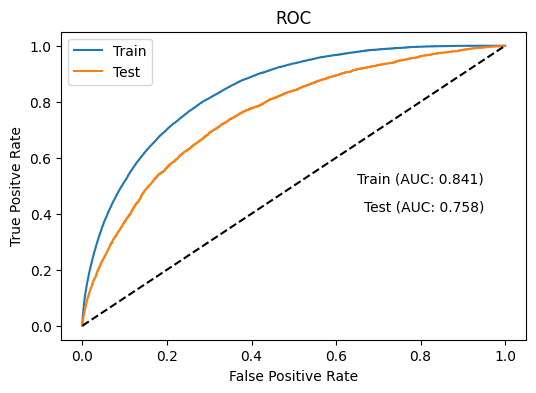

In [53]:
score_list_df_re = evaluate_model(df_train=df_train_re, df_test=df_test_re, model=xgb_model_re, keys=['sk_id_curr', 'target'])

In [56]:
score_list_df_re

,model_name,parameters,rows,columns,%_target,accuracy,auc,precision,recall,f1-score
0,Train: XGBoost,<bound method XGBModel.get_params of XGBClassi...,246008,93,8,0.639,0.841,0.168,0.879,0.282
1,Test: XGBoost,<bound method XGBModel.get_params of XGBClassi...,61503,93,8,0.62,0.758,0.147,0.772,0.247


In [226]:
feature_importance_df_re = feature_importance(model=xgb_model_re)
pd.set_option('display.max_rows', None)
feature_importance_df_re.head()

,feature_name,feature_importance,pct,cum_pct,pct_diff
1,app_ext_source_3,0.06153,6.153,6.153000,NaN
2,app_ext_source_2,0.05741,5.741,11.894000,6.696000
3,app_flag_emp_phone,0.03483,3.483,15.377000,39.331001
4,bureau_credit_type_microloan,0.02625,2.625,18.002001,24.634001
5,cc_bal_cnt_drawings_atm_current_mean,0.02227,2.227,20.229000,15.162000


In [7]:
X, y = prepare_X_y(df=cust_behavior_df, keys=['target'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 555, stratify=y)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

['target']


In [5]:
feature_selection = ['app_ext_source_3', 'app_ext_source_2', 'app_flag_emp_phone', 'bureau_credit_type_microloan', 
                    'cc_bal_cnt_drawings_atm_current_mean', 'app_ext_source_1', 'app_def_30_cnt_social_circle', 'app_amt_goods_price', 
                    'cc_bal_cnt_drawings_current_std', 'app_region_rating_client_w_city', 'bureau_amt_credit_sum_debt_mean', 
                    'app_flag_own_car', 'bureau_credit_type_mortgage', 'app_reg_city_not_work_city', 'app_amt_annuity', 
                    'app_years_employed', 'app_reg_city_not_live_city', 'cc_bal_amt_drawings_current_mean', 'app_flag_cont_mobile', 
                    'app_own_car_age', 'bureau_amt_credit_sum_overdue_std', 'bureau_amt_credit_max_overdue_max', 'app_flag_work_phone', 
                    'cc_bal_amt_drawings_other_current_std', 'bureau_amt_credit_sum_max', 'cc_bal_amt_drawings_atm_current_std', 
                    'bureau_days_credit_enddate_max', 'cc_bal_amt_drawings_atm_current_mean', 'bureau_days_credit_update_mean', 
                    'bureau_amt_credit_sum_mean', 'bureau_days_credit_max', 'cc_bal_sk_dpd_def_std', 'bureau_days_credit_mean', 
                    'app_amt_req_credit_bureau_qrt', 'bureau_credit_type_carloan', 'cc_bal_amt_balance_min', 'bureau_credit_active_active', 
                    'cc_bal_amt_credit_limit_actual_sum', 'app_flag_phone', 'bureau_amt_credit_sum_limit_mean', 'bureau_amt_credit_sum_limit_std', 
                    'cc_bal_amt_payment_current_std', 'cc_bal_months_balance_mean', 'bureau_credit_type_creditcard', 'bureau_days_credit_enddate_mean', 
                    'app_amt_req_credit_bureau_week', 'bureau_amt_credit_sum_debt_min', 'cc_bal_amt_drawings_current_sum', 
                    'cc_bal_name_contract_status_completed', 'bureau_days_credit_std', 'bureau_amt_credit_sum_overdue_mean', 
                    'bureau_credit_currency_currency2', 'bureau_amt_credit_sum_min', 'cc_bal_amt_balance_mean', 'bureau_days_credit_enddate_min', 
                    'bureau_amt_credit_sum_limit_min', 'cc_bal_amt_drawings_atm_current_sum', 'cc_bal_months_balance_max', 'bureau_credit_active_sold', 
                    'bureau_amt_credit_sum_debt_std', 'app_years_last_phone_change', 'cc_bal_amt_credit_limit_actual_std', 'cc_bal_amt_credit_limit_actual_max', 
                    'app_amt_income_total', 'bureau_amt_annuity_min', 'cc_bal_amt_payment_total_current_min', 'bureau_credit_active_closed', 'app_amt_req_credit_bureau_mon', 
                    'cc_bal_cnt_instalment_mature_cum_min', 'bureau_cnt_credit_prolong_sum', 'cc_bal_cnt_drawings_other_current_sum', 'cc_bal_amt_payment_current_min', 
                    'bureau_credit_type_loanforworkingcapitalreplenishment', 'cc_bal_amt_balance_sum', 'app_reg_region_not_live_region', 'app_hour_appr_process_start', 
                    'app_amt_req_credit_bureau_year', 'app_obs_30_cnt_social_circle', 'cc_bal_name_contract_status_sentproposal', 'app_flag_email', 'cc_bal_cnt_drawings_atm_current_sum', 
                    'cc_bal_amt_drawings_pos_current_std', 'cc_bal_amt_drawings_pos_current_min', 'app_reg_region_not_work_region', 'bureau_credit_type_consumercredit', 
                    'app_amt_req_credit_bureau_hour', 'cc_bal_sk_dpd_max', 'cc_bal_amt_inst_min_regularity_min', 'cc_bal_cnt_drawings_other_current_std', 'app_cnt_children', 
                    'cc_bal_cnt_drawings_pos_current_min', 'bureau_credit_day_overdue_mean', 'cc_bal_amt_drawings_current_min']

In [42]:
X_train

,sk_id_curr,app_amt_income_total,app_ext_source_1,app_ext_source_2,app_ext_source_3,app_amt_credit,app_amt_annuity,app_amt_goods_price,app_cnt_children,app_flag_own_car,...,cc_bal_sk_dpd_def_sum,cc_bal_sk_dpd_def_std,cc_bal_name_contract_status_active,cc_bal_name_contract_status_approved,cc_bal_name_contract_status_completed,cc_bal_name_contract_status_demand,cc_bal_name_contract_status_refused,cc_bal_name_contract_status_sentproposal,cc_bal_name_contract_status_signed,cc_bal_num_cc_txn
5660,106622,157500.0,0.000000,0.483274,0.513694,536917.5,29254.5,463500.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
303116,451181,180000.0,0.000000,0.091917,0.654529,216144.0,13351.5,171000.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91354,206094,405000.0,0.000000,0.622703,0.358951,1506816.0,47313.0,1350000.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208800,342004,180000.0,0.209246,0.640877,0.643026,900000.0,31887.0,900000.0,1.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
114944,233282,225000.0,0.293349,0.242643,0.387625,1140156.0,37809.0,1021500.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265723,407802,126000.0,0.000000,0.564010,0.418854,497520.0,31923.0,450000.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6354,107413,72000.0,0.921126,0.352012,0.384207,202500.0,10125.0,202500.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23419,127252,225000.0,0.000000,0.342830,0.000000,182448.0,19777.5,157500.0,1.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
120761,240011,270000.0,0.877091,0.660285,0.404878,1575000.0,43312.5,1575000.0,0.0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,93.0


In [43]:
X_train[feature_selection]

,app_ext_source_3,app_ext_source_2,app_flag_emp_phone,bureau_credit_type_microloan,cc_bal_cnt_drawings_atm_current_mean,app_ext_source_1,app_def_30_cnt_social_circle,app_amt_goods_price,cc_bal_cnt_drawings_current_std,app_region_rating_client_w_city,...,app_reg_region_not_work_region,bureau_credit_type_consumercredit,app_amt_req_credit_bureau_hour,cc_bal_sk_dpd_max,cc_bal_amt_inst_min_regularity_min,cc_bal_cnt_drawings_other_current_std,app_cnt_children,cc_bal_cnt_drawings_pos_current_min,bureau_credit_day_overdue_mean,cc_bal_amt_drawings_current_min
5660,0.513694,0.483274,0,0.0,NaN,0.000000,0.0,463500.0,NaN,2.0,...,0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
303116,0.654529,0.091917,1,1.0,NaN,0.000000,0.0,171000.0,NaN,3.0,...,1,1.0,0.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN
91354,0.358951,0.622703,1,0.0,NaN,0.000000,0.0,1350000.0,NaN,2.0,...,0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
208800,0.643026,0.640877,1,0.0,NaN,0.209246,0.0,900000.0,NaN,2.0,...,0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN
114944,0.387625,0.242643,1,0.0,NaN,0.293349,0.0,1021500.0,NaN,3.0,...,0,1.0,0.0,NaN,NaN,NaN,1.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265723,0.418854,0.564010,1,0.0,NaN,0.000000,0.0,450000.0,NaN,2.0,...,0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
6354,0.384207,0.352012,0,0.0,NaN,0.921126,0.0,202500.0,NaN,1.0,...,0,1.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN
23419,0.000000,0.342830,1,NaN,0.000000,0.000000,0.0,157500.0,0.000000,3.0,...,0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,NaN,0.0
120761,0.404878,0.660285,1,0.0,0.130952,0.877091,0.0,1575000.0,0.832094,2.0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
predicted_portfilio_scores = xgb_model_re_load.predict_proba(X_train[feature_selection])[:, 1]

df_scores = pd.DataFrame({
    'Sk_id_curr': df_train['sk_id_curr'].values,
    'Predicted_Score': predicted_portfilio_scores,
    'Actual': df_train['target']
})

df_scores = df_scores.sort_values(by='Predicted_Score', ascending=False).reset_index(drop=True)
df_scores['Bin'] = pd.qcut(df_scores['Predicted_Score'], 10, labels=False) + 1

bin_pivot = df_scores.groupby('Bin').agg(
    count_target_0=('Actual', lambda x: (x == 0).sum()),
    count_target_1=('Actual', lambda x: (x == 1).sum()),
    count_all=('Actual', 'count'),
    sum_pred_score=('Predicted_Score', 'sum')
).reset_index().sort_values(by='Bin', ascending=False)

bin_pivot['%_correct'] = bin_pivot['count_target_1'] / bin_pivot['count_target_1'].sum() * 100
bin_pivot['%_incorrect'] = bin_pivot['count_target_0'] / bin_pivot['count_target_0'].sum() * 100
bin_pivot['%_population'] = bin_pivot['count_all'] / df_scores.shape[0] * 100
bin_pivot['cumsum_correct'] = bin_pivot['count_target_1'].cumsum()
bin_pivot['cumsum_population'] = bin_pivot['count_all'].cumsum()
bin_pivot['cumsum_%_correct'] = bin_pivot['%_correct'].cumsum()
bin_pivot['cumsum_%_population'] = bin_pivot['%_population'].cumsum()
bin_pivot['%_lift_at_decile'] = bin_pivot['count_target_1'] / (bin_pivot['count_target_1'].sum()/10) * 100

total_correct = bin_pivot['count_target_1'].sum()
bin_pivot['total_lift'] = bin_pivot['cumsum_correct'] / total_correct * 100

bin_pivot['random'] = 100
bin_pivot

,Bin,count_target_0,count_target_1,count_all,sum_pred_score,%_correct,%_incorrect,%_population,cumsum_correct,cumsum_population,cumsum_%_correct,cumsum_%_population,%_lift_at_decile,total_lift,random
9,10,15948,8653,24601,20443.072266,43.569990,7.052019,10.000081,8653,24601,43.569990,10.000081,435.699899,43.569990,100
8,9,20500,4101,24601,17595.468750,20.649547,9.064860,10.000081,12754,49202,64.219537,20.000163,206.495468,64.219537,100
7,8,22026,2575,24601,15414.996094,12.965760,9.739640,10.000081,15329,73803,77.185297,30.000244,129.657603,77.185297,100
6,7,22800,1800,24600,13537.407227,9.063444,10.081893,9.999675,17129,98403,86.248741,39.999919,90.634441,86.248741,100
5,6,23409,1192,24601,11843.160156,6.002014,10.351186,10.000081,18321,123004,92.250755,50.000000,60.020141,92.250755,100
4,5,23863,738,24601,10212.991211,3.716012,10.551939,10.000081,19059,147605,95.966767,60.000081,37.160121,95.966767,100
3,4,24128,472,24600,8628.102539,2.376636,10.669119,9.999675,19531,172205,98.343404,69.999756,23.766365,98.343404,100
2,3,24362,239,24601,7089.118652,1.203424,10.772591,10.000081,19770,196806,99.546828,79.999837,12.034240,99.546828,100
1,2,24519,82,24601,5484.141113,0.412890,10.842015,10.000081,19852,221407,99.959718,89.999919,4.128902,99.959718,100
0,1,24593,8,24601,3379.512939,0.040282,10.874737,10.000081,19860,246008,100.000000,100.000000,0.402820,100.000000,100


In [61]:
345/1590 *100

21.69811320754717

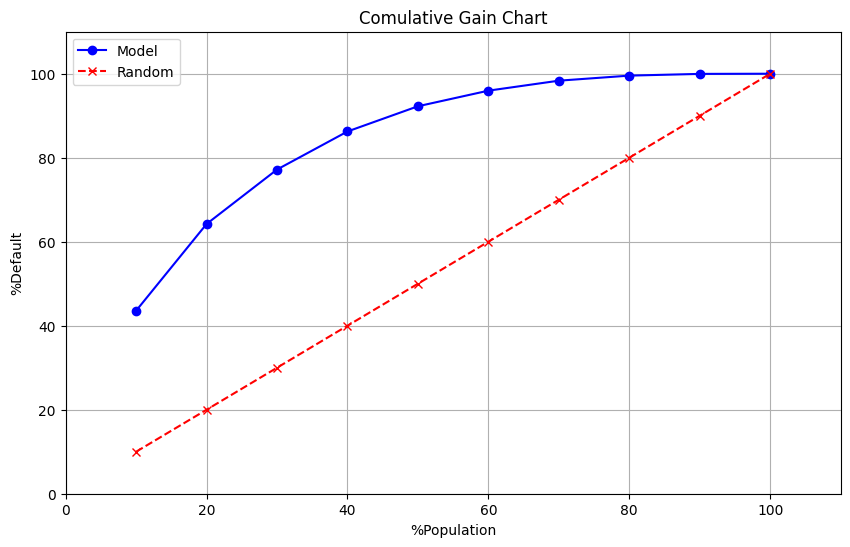

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(bin_pivot['cumsum_%_population'], bin_pivot['cumsum_%_correct'], marker='o', linestyle='-', color='b', label='Model')
plt.plot(bin_pivot['cumsum_%_population'], bin_pivot['cumsum_%_population'], marker='x', linestyle='--', color='r', label='Random')
plt.title('Comulative Gain Chart')
plt.xlabel('%Population')
plt.ylabel('%Default')
plt.legend()
plt.xlim(0, 110)
plt.ylim(0, 110)
plt.grid(True)
plt.show()

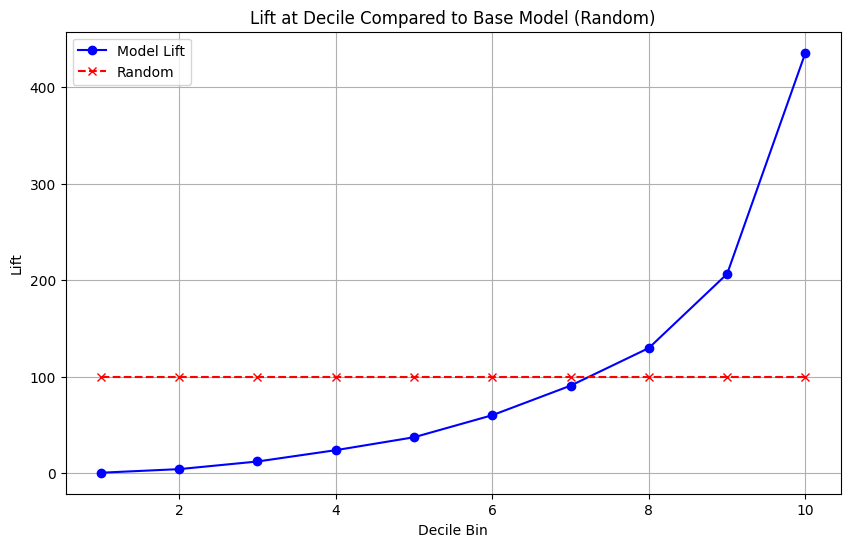

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(bin_pivot['Bin'], bin_pivot['%_lift_at_decile'], marker='o', linestyle='-', color='b', label='Model Lift')
plt.plot(bin_pivot['Bin'], bin_pivot['random'], marker='x', linestyle='--', color='r', label='Random')
plt.title('Lift at Decile Compared to Base Model (Random)')
plt.xlabel('Decile Bin')
plt.ylabel('Lift')
plt.legend()
plt.grid(True)
plt.show()

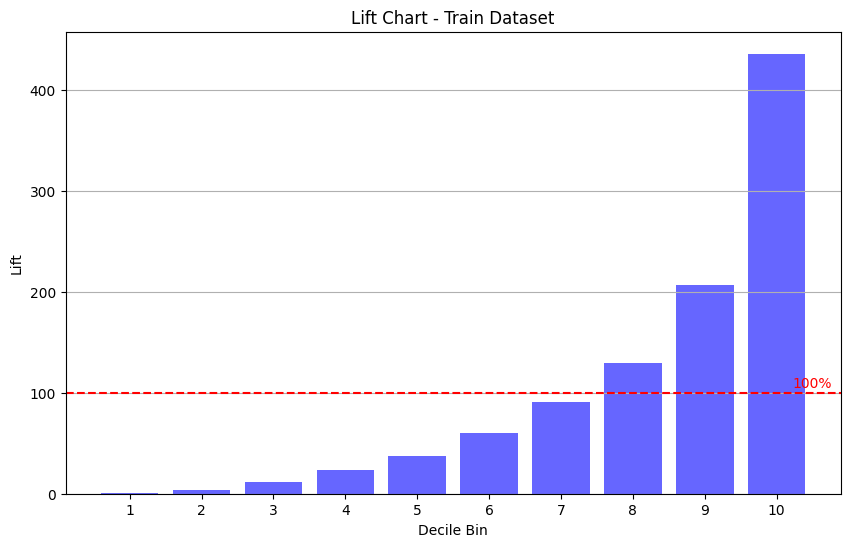

In [9]:
random_line = 100

plt.figure(figsize=(10, 6))
plt.bar(bin_pivot['Bin'], bin_pivot['%_lift_at_decile'], color='b', alpha=0.6)
plt.axhline(y=random_line, color='r', linestyle='--', label='Average Line')
plt.text(10.5, random_line + 2, f'{random_line}%', color='r', ha='center', va='bottom')
plt.title('Lift Chart - Train Dataset')
plt.xlabel('Decile Bin')
plt.ylabel('Lift')
plt.xticks(bin_pivot['Bin'])
plt.grid(axis='y')
plt.show()

In [81]:
predicted_portfilio_scores_proba = xgb_model_re_load.predict_proba(cust_behavior_df[feature_selection])[:, 1]
predicted_portfilio_scores_classify = xgb_model_re_load.predict(cust_behavior_df[feature_selection])

df_scores = pd.DataFrame({
    'Sk_id_curr': cust_behavior_df['sk_id_curr'].values,
    'Predicted_Score': predicted_portfilio_scores_proba,
    'Predict': predicted_portfilio_scores_classify,
    'Actual': cust_behavior_df['target']
})

(246008, 93)


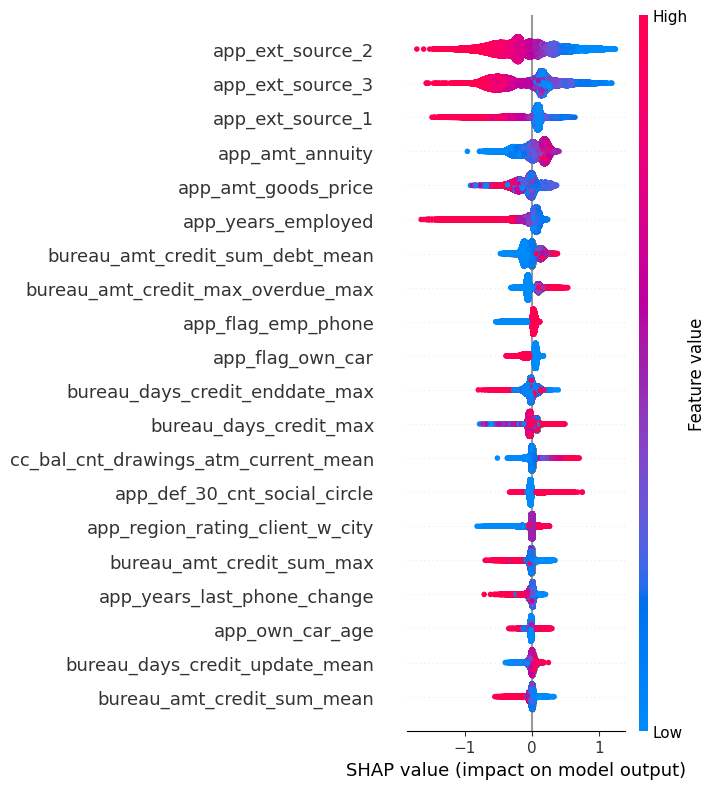

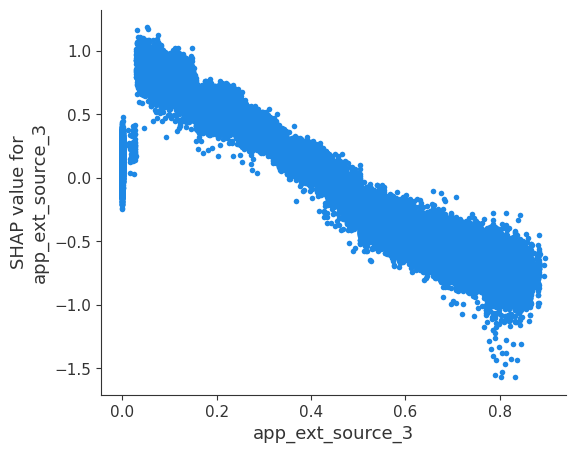

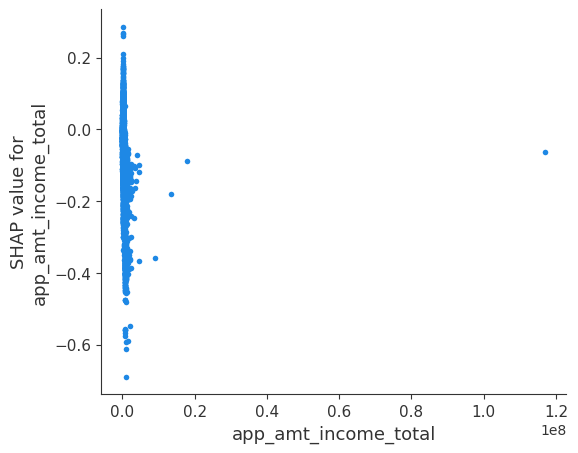

In [67]:
def shap_summary_plot(model, data):
    X_shap = X_train[feature_selection].copy()
    X_shap = X_shap.reset_index(drop=True)
    shap_values = shap.TreeExplainer(xgb_model_re_load).shap_values(X_shap)
    print(shap_values.shape)
    shap.summary_plot(shap_values, X_shap, plot_type='dot', plot_size=[7, 8])
    shap.dependence_plot('app_ext_source_3', shap_values, X_shap, interaction_index=None)
    shap.dependence_plot('app_amt_income_total', shap_values, X_shap, interaction_index=None)
    return shap_values

shap.initjs()
shap_values = shap_summary_plot(xgb_model_re_load, X_train[feature_selection])

In [83]:
df_scores

,Sk_id_curr,Predicted_Score,Predict,Actual
0,100002,0.894563,1,1
1,100003,0.254261,0,0
2,100004,0.252855,0,0
3,100006,0.505798,1,0
4,100007,0.551553,1,0
...,...,...,...,...
307506,456251,0.517002,1,0
307507,456252,0.664488,1,0
307508,456253,0.576549,1,0
307509,456254,0.513116,1,1


In [78]:
file_path_model_credit_score_result = r'\03_[model]_pd_score_result.csv'
df_scores.to_csv(file_path_model_credit_score_result, index=False)